In [764]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

In [765]:
#DataSet Limpio con columnas no utiles segun analisis droppeadas.

oportunidades = pd.read_csv("Train_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
oportunidades['Conversion_Moneda'] = oportunidades['ASP'] / oportunidades['ASP_(converted)']
oportunidades['Total_Amount'] = oportunidades['Total_Amount'] / oportunidades['Conversion_Moneda']
oportunidades['Total_Taxable_Amount'] = oportunidades['Total_Taxable_Amount'] / oportunidades['Conversion_Moneda']
oportunidades = oportunidades[(oportunidades['Stage'] == 'Closed Won') | (oportunidades['Stage'] == 'Closed Lost')]
oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won':1, 'Closed Lost':0})
oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved','Submitted_for_Approval', \
    'Billing_Country','Account_Created_Date', 'Opportunity_Name','Delivery_Year',\
   'Actual_Delivery_Date','Prod_Category_A','Product_Category_B','Delivery_Quarter','Month',\
   'Planned_Delivery_End_Date','Planned_Delivery_Start_Date','ASP_(converted)_Currency','ASP_Currency',\
   'ASP','ASP_(converted)', 'Sales_Contract_No', 'Bureaucratic_Code', 'Opportunity_Created_Date', 'Brand',\
   'Product_Type','Size','Price','Currency','Last_Activity','Quote_Expiry_Date','Last_Modified_Date','Last_Modified_By','ID',\
   'Delivery_Terms','Conversion_Moneda', 'Total_Taxable_Amount_Currency', 'Quote_Type'], axis = 'columns')
oportunidades = oportunidades.dropna()
oportunidades

,Region,Territory,Source,Account_Name,Opportunity_ID,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Product_Family,Product_Name,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount,Stage
2,Americas,NW America,Source_7,Account_Name_1794,2,Person_Name_64,Person_Name_8,Account_Type_5,Opportunity_Type_1,Product_Family_81,Product_Name_91,0,USD,8.386560e+04,8.386560e+04,1
3,Americas,NW America,Source_11,Account_Name_1201,3,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Product_Family_209,Product_Name_432,14,USD,7.421882e+06,7.421882e+06,0
4,Americas,NW America,Source_11,Account_Name_1201,4,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Product_Family_209,Product_Name_432,25,USD,1.335719e+07,1.335719e+07,0
5,Americas,NW America,Source_11,Account_Name_1201,5,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Product_Family_209,Product_Name_432,28,USD,1.483828e+07,1.483828e+07,0
6,Americas,NW America,Source_11,Account_Name_1201,6,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Product_Family_164,Product_Name_308,7,USD,2.659495e+06,2.659495e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16922,APAC,Japan,Source_7,Account_Name_1294,12785,Person_Name_66,Person_Name_66,Account_Type_2,Opportunity_Type_1,Product_Family_243,Product_Name_508,0,USD,1.320000e+04,6.422401e+06,1
16923,APAC,Japan,Source_3,Account_Name_1074,12786,Person_Name_61,Person_Name_66,Account_Type_0,Opportunity_Type_1,Product_Family_77,Product_Name_100,0,JPY,1.096295e+05,1.096295e+05,1
16924,APAC,Japan,Source_3,Account_Name_1074,12787,Person_Name_61,Person_Name_66,Account_Type_0,Opportunity_Type_1,Product_Family_73,Product_Name_85,0,JPY,1.075213e+05,1.075213e+05,1
16925,APAC,Japan,Source_11,Account_Name_1522,12788,Person_Name_50,Person_Name_30,Account_Type_0,Opportunity_Type_10,Product_Family_77,Product_Name_100,0,JPY,1.576650e+05,1.576650e+05,1


In [766]:
oportunidades['Source '].value_counts()

None         5962
Source_7     2639
Source_9     1400
Source_11    1333
Source_13     589
Source_3      373
Source_1      105
Source_10      99
Source_2       83
Source_4       35
Source_6       16
Source_0        6
Source_5        1
Source_12       1
Name: Source , dtype: int64

In [767]:
# Encodeos necesarios:
#----------------------------------------------------------------------------------------------------
# Total_Amount_Currency(AUD y JPY)
# Region (APAC)
# Territorio (Mean Stage)
# Dif_Amount(TAm-TTAm)
# TRF > 0
# Product_Family(En base a ranking o mean de Stage)
# Product_Name(En base a ranking o mean de Stage)
# Total Amount y Total Tax hay que dropearlos despues del Dif_Amount
# Account Name (Ranking o Mean Stage)
# Opportunity Owner (Ranking o Mean Stage)
# Account Owner (Ranking o Mean Stage)
# Account Type (Ranking o Mean Stage)
# Opportunity Type (Ranking o Mean Stage)
# Source (Decidir el encodeo)
#---------------------------------------------------------------------------------------------------

In [768]:
# Total_Amount_Currency(AUD y JPY)
# Region (APAC)

oportunidades['Currency_Es_JPY_O_AUD'] = ((oportunidades['Total_Amount_Currency'] == 'AUD') | \
                                  (oportunidades['Total_Amount_Currency'] == 'JPY')).replace({True:1,False:0})

oportunidades['Region_Es_APAC'] = (oportunidades['Region'] == 'APAC').replace({True:1,False:0})
oportunidades = oportunidades.drop(columns=['Region','Total_Amount_Currency'])
#oportunidades = pd.concat([oportunidades,pd.get_dummies(oportunidades['Region'])],axis='columns')

In [769]:
# Territorio (Mean TRF)

gby_terr = oportunidades.groupby('Territory').agg({'Stage':'mean'})
gby_terr['Stage'] = gby_terr['Stage'].replace({np.nan:(gby_terr['Stage'].mean())})
terrs_sorted = gby_terr.sort_values(by='Stage')
terrs_sorted['Stage'] = np.log(terrs_sorted['Stage'])
terrs_sorted = terrs_sorted.reset_index()
terrs_sorted.columns = ['Territory', 'Encoding_Territory']
oportunidades = oportunidades.merge(terrs_sorted, on='Territory')
oportunidades = oportunidades.drop(columns=['Territory'])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [770]:
# Dif_Amount(TAm-TTAm)

amounts = oportunidades.groupby('Opportunity_ID').agg({'Total_Amount':'sum','Total_Taxable_Amount':'mean'})
amounts['Diferencia_Amounts'] = amounts['Total_Amount']-amounts['Total_Taxable_Amount']
amounts = amounts.drop(columns = ['Total_Amount','Total_Taxable_Amount'])
amounts = amounts.reset_index()
oportunidades = oportunidades.merge(amounts, on='Opportunity_ID')
#oportunidades = oportunidades.drop(columns = ['Total_Amount','Total_Taxable_Amount'])


In [771]:
# TRF > 0

trf = oportunidades.groupby('Opportunity_ID').agg({'TRF':'sum'})
trf['TRF_Mayor_A_0'] = trf['TRF']>0
trf = trf.drop(columns=['TRF'])
trf = trf.reset_index()
oportunidades = oportunidades.merge(trf, on='Opportunity_ID')
oportunidades = oportunidades.drop(columns=['TRF'])
oportunidades['TRF_Mayor_A_0'] = oportunidades['TRF_Mayor_A_0'].replace({True:1,False:0})

In [772]:
# Product_Family(Mean Stage)

gby_prod_fam = oportunidades.groupby('Product_Family').agg({'Stage':'mean'})
gby_prod_fam['Stage'] = gby_prod_fam['Stage'].replace({np.nan:(gby_prod_fam['Stage'].mean())})
p_fam_sorted = gby_prod_fam.sort_values(by='Stage')
p_fam_sorted['Stage'] = p_fam_sorted['Stage']
p_fam_sorted = p_fam_sorted.reset_index()
p_fam_sorted.columns = ['Product_Family', 'Encoding_Prod_Family']
prior = oportunidades['Stage'].mean()
n = len(gby_prod_fam)
mu = gby_prod_fam['Stage']
mu_smoothed = (n * mu + 5 * prior) / (n + 5)
mu_smoothed = pd.DataFrame(mu_smoothed)
p_fam_sorted['Encoding_Prod_Family'] = mu_smoothed.reset_index().Stage
oportunidades = oportunidades.merge(p_fam_sorted, on='Product_Family')
oportunidades = oportunidades.drop(columns=['Product_Family'])

In [773]:
# Product_Name(En base a ranking)

gby_prod_name = oportunidades.groupby('Product_Name').agg({'Stage':'mean'})
gby_prod_name['Stage'] = gby_prod_name['Stage'].replace({np.nan:(gby_prod_name['Stage'].mean())})
p_name_sorted = gby_prod_name.sort_values(by='Stage')
p_name_sorted = p_name_sorted.reset_index()
p_name_sorted = p_name_sorted.reset_index()
p_name_sorted = p_name_sorted.drop(columns=['Stage'])
p_name_sorted.columns = ['Encoding_Prod_Name', 'Product_Name']
p_name_sorted['Encoding_Prod_Name'] = 1/np.log(p_name_sorted['Encoding_Prod_Name'])
oportunidades = oportunidades.merge(p_name_sorted, on='Product_Name')
oportunidades = oportunidades.drop(columns=['Product_Name'])

In [774]:
# Account Name (Mean Stage)
gby_acc_name = oportunidades.groupby('Account_Name').agg({'Stage':'mean'})
gby_acc_name['Stage'] = gby_acc_name['Stage'].replace({np.nan:(gby_acc_name['Stage'].mean())})
acc_name_sorted = gby_acc_name.sort_values(by='Stage')
acc_name_sorted = acc_name_sorted.reset_index()
acc_name_sorted.columns = ['Account_Name', 'Encoding_Account_Name']
prior = oportunidades['Stage'].mean()
n = len(gby_acc_name)
mu = gby_acc_name['Stage']
mu_smoothed = (n * mu + 5 * prior) / (n + 5)
mu_smoothed = pd.DataFrame(mu_smoothed)
acc_name_sorted['Encoding_Account_Name'] = mu_smoothed.reset_index().Stage
oportunidades = oportunidades.merge(acc_name_sorted, on='Account_Name')
oportunidades = oportunidades.drop(columns=['Account_Name'])

In [775]:
# Opportunity Owner (Ranking)

gby_op_ow = oportunidades.groupby('Opportunity_Owner').agg({'Stage':'mean'})
gby_op_ow['Stage'] = gby_op_ow['Stage'].replace({np.nan:(gby_op_ow['Stage'].mean())})
op_ow_sorted = gby_op_ow.sort_values(by='Stage')
op_ow_sorted = op_ow_sorted.reset_index()
op_ow_sorted = op_ow_sorted.reset_index()
op_ow_sorted = op_ow_sorted.drop(columns=['Stage'])
op_ow_sorted.columns = ['Encoding_Opportunity_Owner', 'Opportunity_Owner']
oportunidades = oportunidades.merge(op_ow_sorted, on='Opportunity_Owner')
oportunidades = oportunidades.drop(columns=['Opportunity_Owner'])

In [776]:
# Account Owner (Mean Stage)

gby_acc_ow = oportunidades.groupby('Account_Owner').agg({'Stage':'mean'})
gby_acc_ow['Stage'] = gby_acc_ow['Stage'].replace({np.nan:(gby_acc_ow['Stage'].mean())})
acc_ow_sorted = gby_acc_ow.sort_values(by='Stage')
acc_ow_sorted = acc_ow_sorted.reset_index()
acc_ow_sorted.columns = ['Account_Owner', 'Encoding_Account_Owner']
prior = oportunidades['Stage'].mean()
n = len(gby_acc_ow)
mu = gby_acc_ow['Stage']
mu_smoothed = (n * mu + 5 * prior) / (n + 5)
mu_smoothed = pd.DataFrame(mu_smoothed)
acc_ow_sorted['Encoding_Account_Owner'] = mu_smoothed.reset_index().Stage
oportunidades = oportunidades.merge(acc_ow_sorted, on='Account_Owner')
oportunidades = oportunidades.drop(columns=['Account_Owner'])

In [777]:
# Account Type (Ranking)

gby_acc_type = oportunidades.groupby('Account_Type').agg({'Stage':'mean'})
gby_acc_type['Stage'] = gby_acc_type['Stage'].replace({np.nan:(gby_acc_type['Stage'].mean())})
acc_type_sorted = gby_acc_type.sort_values(by='Stage')
acc_type_sorted = acc_type_sorted.reset_index()
acc_type_sorted = acc_type_sorted.reset_index()
acc_type_sorted = acc_type_sorted.drop(columns=['Stage'])
acc_type_sorted.columns = ['Encoding_Account_Type', 'Account_Type']
acc_type_sorted['Encoding_Account_Type'] = (1/acc_type_sorted['Encoding_Account_Type'])**10
oportunidades = oportunidades.merge(acc_type_sorted, on='Account_Type')
oportunidades = oportunidades.drop(columns=['Account_Type'])

In [778]:
# Opportunity Type (Mean Stage)

gby_op_type = oportunidades.groupby('Opportunity_Type').agg({'Stage':'mean'})
gby_op_type['Stage'] = gby_op_type['Stage'].replace({np.nan:(gby_op_type['Stage'].mean())})
op_type_sorted = gby_op_type.sort_values(by='Stage')
op_type_sorted = op_type_sorted.reset_index()
op_type_sorted.columns = ['Opportunity_Type', 'Encoding_Opportunity_Type']
prior = oportunidades['Stage'].mean()
n = len(gby_op_type)
mu = gby_op_type['Stage']
mu_smoothed = (n * mu + 5 * prior) / (n + 5)
mu_smoothed = pd.DataFrame(mu_smoothed)
op_type_sorted['Encoding_Opportunity_Type'] = mu_smoothed.reset_index().Stage
#op_type_sorted['Encoding_Opportunity_Type'] = 1/np.sqrt(op_type_sorted['Encoding_Opportunity_Type'])
oportunidades = oportunidades.merge(op_type_sorted, on='Opportunity_Type')
oportunidades = oportunidades.drop(columns=['Opportunity_Type'])



In [779]:
# Source (En base al mean del Stage)
source_enc = oportunidades.groupby('Source ').agg({'Stage':'mean'})
source_enc = source_enc.reset_index()
source_enc.columns = ['Source ', 'Encoding_Source']
prior = oportunidades['Stage'].mean()
n = len(source_enc)
mu = source_enc['Encoding_Source']
mu_smoothed = (n * mu + 5 * prior) / (n + 5)
mu_smoothed = pd.DataFrame(mu_smoothed)
source_enc['Encoding_Source'] = mu_smoothed.reset_index().Encoding_Source
oportunidades = oportunidades.merge(source_enc, on='Source ', how='left')
oportunidades = oportunidades.drop(columns=['Source '])
oportunidades

,Opportunity_ID,Total_Amount,Total_Taxable_Amount,Stage,Currency_Es_JPY_O_AUD,Region_Es_APAC,Encoding_Territory,Diferencia_Amounts,TRF_Mayor_A_0,Encoding_Prod_Family,Encoding_Prod_Name,Encoding_Account_Name,Encoding_Opportunity_Owner,Encoding_Account_Owner,Encoding_Account_Type,Encoding_Opportunity_Type,Encoding_Source
0,2,83865.60,83865.60,1,0,0,-0.460060,0.0,0,0.659892,0.168420,0.250939,39,0.489688,1.693509e-05,0.259690,0.505109
1,1315,183367.80,183367.80,1,0,0,-0.460060,0.0,0,0.990477,0.175220,0.250939,39,0.489688,1.693509e-05,0.259690,0.505109
2,1316,257588.10,257588.10,1,0,0,-0.460060,0.0,0,0.990477,0.175220,0.250939,39,0.489688,1.693509e-05,0.259690,0.505109
3,2889,32744.25,32744.25,1,0,0,-0.460060,0.0,0,0.990477,0.175220,0.250939,39,0.489688,1.693509e-05,0.259690,0.505109
4,7,50688.00,50688.00,1,0,0,-0.460060,0.0,0,0.659892,0.172713,0.250939,39,0.489688,1.693509e-05,0.259690,0.505109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12637,3517,900007.20,900007.20,0,0,1,-1.299283,0.0,1,0.868171,0.200383,0.001702,14,0.687505,1.024000e-07,0.278043,0.565601
12638,3518,900007.20,900007.20,0,0,1,-1.299283,0.0,1,0.868171,0.200383,0.001702,14,0.687505,1.024000e-07,0.278043,0.565601
12639,2782,570000.00,570000.00,1,0,1,-0.378458,0.0,1,0.990477,0.167757,0.998653,52,0.428852,1.024000e-07,0.278043,0.505109
12640,2783,616740.00,616740.00,1,0,1,-0.378458,0.0,1,0.990477,0.167757,0.998653,52,0.428852,1.024000e-07,0.278043,0.505109


In [780]:
oportunidades

,Opportunity_ID,Total_Amount,Total_Taxable_Amount,Stage,Currency_Es_JPY_O_AUD,Region_Es_APAC,Encoding_Territory,Diferencia_Amounts,TRF_Mayor_A_0,Encoding_Prod_Family,Encoding_Prod_Name,Encoding_Account_Name,Encoding_Opportunity_Owner,Encoding_Account_Owner,Encoding_Account_Type,Encoding_Opportunity_Type,Encoding_Source
0,2,83865.60,83865.60,1,0,0,-0.460060,0.0,0,0.659892,0.168420,0.250939,39,0.489688,1.693509e-05,0.259690,0.505109
1,1315,183367.80,183367.80,1,0,0,-0.460060,0.0,0,0.990477,0.175220,0.250939,39,0.489688,1.693509e-05,0.259690,0.505109
2,1316,257588.10,257588.10,1,0,0,-0.460060,0.0,0,0.990477,0.175220,0.250939,39,0.489688,1.693509e-05,0.259690,0.505109
3,2889,32744.25,32744.25,1,0,0,-0.460060,0.0,0,0.990477,0.175220,0.250939,39,0.489688,1.693509e-05,0.259690,0.505109
4,7,50688.00,50688.00,1,0,0,-0.460060,0.0,0,0.659892,0.172713,0.250939,39,0.489688,1.693509e-05,0.259690,0.505109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12637,3517,900007.20,900007.20,0,0,1,-1.299283,0.0,1,0.868171,0.200383,0.001702,14,0.687505,1.024000e-07,0.278043,0.565601
12638,3518,900007.20,900007.20,0,0,1,-1.299283,0.0,1,0.868171,0.200383,0.001702,14,0.687505,1.024000e-07,0.278043,0.565601
12639,2782,570000.00,570000.00,1,0,1,-0.378458,0.0,1,0.990477,0.167757,0.998653,52,0.428852,1.024000e-07,0.278043,0.505109
12640,2783,616740.00,616740.00,1,0,1,-0.378458,0.0,1,0.990477,0.167757,0.998653,52,0.428852,1.024000e-07,0.278043,0.505109


In [781]:
params ={
 'alpha': 0.0001,
 'colsample_bytree': 0.7999999999999999,
 'gamma': 0.15000000000000002,
 'learning_rate': 0.02,
 'max_depth': 7,
 'subsample': 0.8999999999999999}

xg_reg = xgb.XGBRegressor(objective='binary:logistic', 
                         n_estimators = 25, 
                         eval_metric='logloss',
                         alpha = params['alpha'],
                         colsample_bytree = params['colsample_bytree'],
                         gamma = params['gamma'],
                         max_depth = params['max_depth'],
                         subsample = params['subsample'],
                         eval_metrics = 'logloss')

x_train = oportunidades.groupby('Opportunity_ID').agg({
                                 'Total_Amount':'sum',
                                 'Total_Taxable_Amount':'mean',\
                                 'Encoding_Source': lambda x:x.value_counts().index[0],
                                 #'Currency_Es_JPY_O_AUD':'mean', 
                                 #'Region_Es_APAC':'mean',\
                                 #'APAC':'mean','EMEA':'mean','Americas':'mean',
                                 'Encoding_Territory':'mean', 
                                 'Diferencia_Amounts':'mean', 
                                 #'TRF_Mayor_A_0':'mean',\
                                 'Encoding_Prod_Family':'mean','Encoding_Prod_Name':'mean','Encoding_Account_Name':'mean',\
                                 'Encoding_Opportunity_Owner':'mean','Encoding_Account_Owner':'mean','Encoding_Account_Type':'mean',\
                                  'Encoding_Opportunity_Type':'mean'})

y_train = oportunidades.groupby('Opportunity_ID').agg({'Stage':'max'})
division_x_train, division_x_test, division_y_train, division_y_test = train_test_split(x_train, y_train, test_size = 0.3,\
                                                                                       random_state = 123)
xg_reg.fit(division_x_train, division_y_train)
xg_reg.score(division_x_test, division_y_test)

[17:06:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { eval_metrics } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




0.3838156750738787

In [782]:
accuracy_score(division_y_test, xg_reg.predict(division_x_test).round())

0.7906976744186046

In [783]:
log_loss(division_y_test, xg_reg.predict(division_x_test))

0.5227412643588514

In [784]:
#Entrenamos con todo el set de train

xg_reg.fit(x_train, y_train)

[17:06:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { eval_metrics } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(alpha=0.0001, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7999999999999999, eval_metric='logloss',
             eval_metrics='logloss', gamma=0.15000000000000002, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=250, n_jobs=12, num_parallel_tree=1,
             objective='binary:logistic', random_state=0,
             reg_alpha=9.99999975e-05, reg_lambda=1, scale_pos_weight=1,
             subsample=0.8999999999999999, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [785]:
#Armamos el set de test
oportunidades = pd.read_csv("Test_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
#oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
oportunidades['Conversion_Moneda'] = oportunidades['ASP'] / oportunidades['ASP_(converted)']
oportunidades['Total_Amount'] = oportunidades['Total_Amount'] / oportunidades['Conversion_Moneda']
oportunidades['Total_Taxable_Amount'] = oportunidades['Total_Taxable_Amount'] / oportunidades['Conversion_Moneda']
#oportunidades = oportunidades[(oportunidades['Stage'] == 'Closed Won') | (oportunidades['Stage'] == 'Closed Lost')]
#oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won':1, 'Closed Lost':0})
oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved','Submitted_for_Approval', \
    'Billing_Country','Account_Created_Date', 'Opportunity_Name','Delivery_Year',\
   'Actual_Delivery_Date','Prod_Category_A','Product_Category_B','Delivery_Quarter','Month',\
   'Planned_Delivery_End_Date','Planned_Delivery_Start_Date','ASP_(converted)_Currency','ASP_Currency',\
   'ASP','ASP_(converted)', 'Sales_Contract_No', 'Bureaucratic_Code', 'Opportunity_Created_Date', 'Brand',\
   'Product_Type','Size','Price','Currency','Last_Activity','Quote_Expiry_Date','Last_Modified_Date','Last_Modified_By','ID',\
   'Delivery_Terms','Conversion_Moneda', 'Total_Taxable_Amount_Currency', 'Quote_Type'], axis = 'columns')

In [786]:
# Total_Amount_Currency(AUD y JPY)
# Region (APAC)

oportunidades['Currency_Es_JPY_O_AUD'] = ((oportunidades['Total_Amount_Currency'] == 'AUD') | \
                                  (oportunidades['Total_Amount_Currency'] == 'JPY')).replace({True:1,False:0})
oportunidades['Region_Es_APAC'] = (oportunidades['Region'] == 'APAC').replace({True:1,False:0})
oportunidades = oportunidades.drop(columns=['Region','Total_Amount_Currency'])
#oportunidades = pd.concat([oportunidades,pd.get_dummies(oportunidades['Region'])],axis='columns')

# Territorio (Mean Stage)

oportunidades = oportunidades.merge(terrs_sorted, on='Territory', how='left')
oportunidades = oportunidades.drop(columns=['Territory'])
oportunidades['Encoding_Territory'] = oportunidades['Encoding_Territory'].replace\
                                    ({np.nan:oportunidades['Encoding_Territory'].mean()})

# Dif_Amount(TAm-TTAm)

amounts = oportunidades.groupby('Opportunity_ID').agg({'Total_Amount':'sum','Total_Taxable_Amount':'mean'})
amounts['Diferencia_Amounts'] = amounts['Total_Amount']-amounts['Total_Taxable_Amount']
amounts = amounts.drop(columns = ['Total_Amount','Total_Taxable_Amount'])
amounts = amounts.reset_index()
oportunidades = oportunidades.merge(amounts, on='Opportunity_ID', how='left')
#oportunidades = oportunidades.drop(columns = ['Total_Amount','Total_Taxable_Amount'])

# TRF > 0

trf = oportunidades.groupby('Opportunity_ID').agg({'TRF':'sum'})
trf['TRF_Mayor_A_0'] = trf['TRF']>0
trf = trf.drop(columns=['TRF'])
trf = trf.reset_index()
oportunidades = oportunidades.merge(trf, on='Opportunity_ID', how='left')
oportunidades = oportunidades.drop(columns=['TRF'])
oportunidades['TRF_Mayor_A_0'] = oportunidades['TRF_Mayor_A_0'].replace({True:1,False:0})

# Product_Family (mean Stage)

oportunidades = oportunidades.merge(p_fam_sorted, on='Product_Family', how='left')
oportunidades = oportunidades.drop(columns=['Product_Family'])
oportunidades['Encoding_Prod_Family'] = oportunidades['Encoding_Prod_Family'].replace\
                                    ({np.nan:oportunidades['Encoding_Prod_Family'].mean()})

# Product_Name (En base a ranking)

oportunidades = oportunidades.merge(p_name_sorted, on='Product_Name', how='left')
oportunidades = oportunidades.drop(columns=['Product_Name'])
oportunidades['Encoding_Prod_Name'] = oportunidades['Encoding_Prod_Name'].replace\
                                    ({np.nan:oportunidades['Encoding_Prod_Name'].mean()})

# Account_Name (mean stage)

oportunidades = oportunidades.merge(acc_name_sorted, on='Account_Name', how='left')
oportunidades = oportunidades.drop(columns=['Account_Name'])
oportunidades['Encoding_Account_Name'] = oportunidades['Encoding_Account_Name'].replace\
                                    ({np.nan:oportunidades['Encoding_Account_Name'].mean()})

# Opportunity_Owner (ranking)

oportunidades = oportunidades.merge(op_ow_sorted, on='Opportunity_Owner', how='left')
oportunidades = oportunidades.drop(columns=['Opportunity_Owner'])
oportunidades['Encoding_Opportunity_Owner'] = oportunidades['Encoding_Opportunity_Owner'].replace\
                                    ({np.nan:oportunidades['Encoding_Opportunity_Owner'].mean()})

# Account_Owner (mean stage)

oportunidades = oportunidades.merge(acc_ow_sorted, on='Account_Owner', how='left')
oportunidades = oportunidades.drop(columns=['Account_Owner'])
oportunidades['Encoding_Account_Owner'] = oportunidades['Encoding_Account_Owner'].replace\
                                    ({np.nan:oportunidades['Encoding_Account_Owner'].mean()})

# Account_Type (ranking)

oportunidades = oportunidades.merge(acc_type_sorted, on='Account_Type', how='left')
oportunidades = oportunidades.drop(columns=['Account_Type'])
oportunidades['Encoding_Account_Type'] = oportunidades['Encoding_Account_Type'].replace\
                                    ({np.nan:oportunidades['Encoding_Account_Type'].mean()})

# Opportunity_Type (mean Stage)

oportunidades = oportunidades.merge(op_type_sorted, on='Opportunity_Type', how='left')
oportunidades = oportunidades.drop(columns=['Opportunity_Type'])
oportunidades['Encoding_Opportunity_Type'] = oportunidades['Encoding_Opportunity_Type'].replace\
                                    ({np.nan:oportunidades['Encoding_Opportunity_Type'].mean()})

# Source (En base a sum de Total_Amount)

oportunidades = oportunidades.merge(source_enc, on='Source ', how='left')
oportunidades = oportunidades.drop(columns=['Source '])
#oportunidades = pd.concat([oportunidades,pd.get_dummies(oportunidades['Source '])], axis='columns')

In [787]:
oportunidades

,Opportunity_ID,Total_Amount,Total_Taxable_Amount,Currency_Es_JPY_O_AUD,Region_Es_APAC,Encoding_Territory,Diferencia_Amounts,TRF_Mayor_A_0,Encoding_Prod_Family,Encoding_Prod_Name,Encoding_Account_Name,Encoding_Opportunity_Owner,Encoding_Account_Owner,Encoding_Account_Type,Encoding_Opportunity_Type,Encoding_Source
0,10689,1.835109e+05,4.155905e+05,0,0,-0.498011,0.542847,0,0.696378,0.189305,0.998653,43.0,0.798493,1.653817e-08,0.667611,0.505109
1,10689,8.893111e+04,4.155853e+05,0,0,-0.498011,0.542847,0,0.664328,0.177923,0.998653,43.0,0.798493,1.653817e-08,0.667611,0.505109
2,10689,1.431452e+05,4.155843e+05,0,0,-0.498011,0.542847,0,0.659892,0.170960,0.998653,43.0,0.798493,1.653817e-08,0.667611,0.505109
3,10690,2.752664e+05,8.571347e+05,0,0,-0.498011,1.256595,1,0.696378,0.189305,0.998653,43.0,0.798493,1.653817e-08,0.667611,0.505109
4,10690,1.778622e+05,8.571242e+05,0,0,-0.498011,1.256595,1,0.664328,0.177923,0.998653,43.0,0.798493,1.653817e-08,0.667611,0.505109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,12341,NaN,NaN,1,1,-0.378458,-269.715000,0,0.659892,0.184787,0.001702,41.0,0.633787,1.024000e-07,0.259690,0.565601
2547,12341,3.883896e+02,6.581046e+02,1,1,-0.378458,-269.715000,0,0.012029,0.172531,0.001702,41.0,0.633787,1.024000e-07,0.259690,0.565601
2548,12357,4.079929e+06,4.079929e+06,0,1,-0.378458,0.000000,1,0.659892,0.185877,0.998653,45.0,0.428852,1.024000e-07,0.259690,0.516288
2549,12361,4.557082e+04,4.557082e+04,1,1,-0.378458,0.000000,0,0.990477,0.175017,0.001702,40.0,0.633787,1.693509e-05,0.259690,0.565601


In [788]:
x_test = oportunidades.groupby('Opportunity_ID').agg({
                                 'Total_Amount':'sum',
                                 'Total_Taxable_Amount':'mean',\
                                 'Encoding_Source': lambda x:x.value_counts().index[0],
                                 #'Currency_Es_JPY_O_AUD':'mean', 
                                 #'Region_Es_APAC':'mean',\
                                 #'APAC':'mean','EMEA':'mean','Americas':'mean',
                                 'Encoding_Territory':'mean', 
                                 'Diferencia_Amounts':'mean', 
                                 #'TRF_Mayor_A_0':'mean',\
                                 'Encoding_Prod_Family':'mean','Encoding_Prod_Name':'mean','Encoding_Account_Name':'mean',\
                                 'Encoding_Opportunity_Owner':'mean','Encoding_Account_Owner':'mean','Encoding_Account_Type':'mean',\
                                 'Encoding_Opportunity_Type':'mean'})

predictions = xg_reg.predict(x_test)
x_test = x_test.reset_index()
serie1 = pd.DataFrame(x_test['Opportunity_ID'])
serie2 = pd.DataFrame(predictions)
df = pd.DataFrame(serie1)
df['Target'] = serie2
df.columns = ['Opportunity_ID', 'Target']
df

,Opportunity_ID,Target
0,10689,0.238790
1,10690,0.117603
2,10691,0.935958
3,10692,0.340846
4,10693,0.983947
...,...,...
1562,12364,0.960619
1563,12365,0.142368
1564,12366,0.036315
1565,12367,0.423912


In [789]:
df.to_csv("Predicciones.csv", index=False)

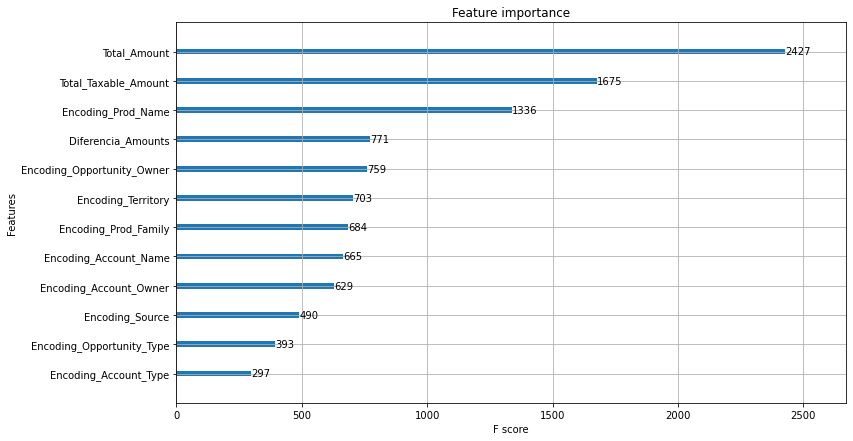

In [790]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)